In [1]:
%load_ext autoreload
%autoreload 2

import parenclitic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, SVG
import igraph

In [2]:
from configurations.load_data_down_GSE52588 import load_data_down_GSE52588
from configurations.config_down_GSE52588 import config
#from configurations.config_down_GSE52588_synthetic import config_s

X, y, mask, all_features_names = load_data_down_GSE52588()

D:\PC\UNN\Science\Gerontology\data\GSE52588\GSE52588_average_beta.txt
Data loaded:  1.2023637000000003
float32 (14756, 87)
(87, 14756) 14756


In [3]:
group_names = ["DS", "Siblings", "Mothers"]
groups = ["mongoloids_mask", "siblings_mask", "mothers_mask"]
group_masks = [0] * 3
for j, group_name in enumerate(groups):
    group_masks[j] = config.params[group_name].value

In [4]:
config.ofname(["graphs", "g"], ext = ".tsv", include_set = config.params_sets["graph"])

'D:\\PC\\UNN\\Science\\Gerontology\\data\\GSE52588\\params\\num_genes_14756\\kde_mask_mongoloids_mask\\algorithm_pdf\\thr_type_best\\division_rule_non_control\\graphs\\graph_id_sample_0.tsv'

In [5]:
def load_subset():
    path_gene_subset = config.ofname(["gene_subsets", "kde_siblings_union_ds_graph_vertices"], ext = ".tsv", include_set = config.params_sets["gene_subsets"])
    print(path_gene_subset)
    df = pd.read_csv(path_gene_subset, sep = '\t', index_col = 0)
    gene_subset = df["genes"].values
    _, gene_subset_ids, _ = np.intersect1d(all_features_names, gene_subset, return_indices = True)
    return gene_subset_ids
gene_subset_ids = load_subset()
gene_subset_ids = gene_subset_ids[:200]
Xs = X[:, gene_subset_ids]
Xs.shape

D:\PC\UNN\Science\Gerontology\data\GSE52588\gene_subsets\kde_siblings_union_ds_graph_vertices.tsv


(87, 200)

In [6]:
def load_subset_edges():
    gene_to_id = {}
    for i, gene in enumerate(all_features_names):
        gene_to_id[gene] = i
    path_gene_subset = config.ofname(["gene_subsets", "kde_siblings_ds_union_graph"], ext = ".tsv", include_set = config.params_sets["gene_subsets"])
    print(path_gene_subset)
    df = pd.read_csv(path_gene_subset, sep = '\t', index_col = 0)
    gene_1 = df["gene_1"].values
    gene_2 = df["gene_2"].values
    gene_subset_ids_1 = []
    for gene in gene_1:
        gene_subset_ids_1.append(gene_to_id[gene])
    gene_subset_ids_2 = []
    for gene in gene_2:
        gene_subset_ids_2.append(gene_to_id[gene])
    gene_subset_ids_1 = np.array(gene_subset_ids_1)
    gene_subset_ids_2 = np.array(gene_subset_ids_2)
    gene_subset_ids = np.vstack((gene_subset_ids_1, gene_subset_ids_2)).T
    return gene_subset_ids
gene_subset_edges_ids = load_subset_edges()
print(gene_subset_edges_ids.shape)

gene_subset_ids = np.concatenate([gene_subset_edges_ids[:, 0], gene_subset_edges_ids[:, 1]])
gene_subset_ids = np.unique(gene_subset_ids)
print(gene_subset_ids.shape)

to_new_ids = {}
for i, x in enumerate(gene_subset_ids):
    to_new_ids[x] = i

for i in range(gene_subset_edges_ids.shape[0]):
    gene_subset_edges_ids[i, 0] = to_new_ids[gene_subset_edges_ids[i, 0]]
    gene_subset_edges_ids[i, 1] = to_new_ids[gene_subset_edges_ids[i, 1]]
#gene_subset_ids = gene_subset_ids[:200]
Xs = X[:, gene_subset_ids]
Xs.shape

D:\PC\UNN\Science\Gerontology\data\GSE52588\gene_subsets\kde_siblings_ds_union_graph.tsv
(3458, 2)
(1380,)


(87, 1380)

# Subset gene pairs for parenclitic

In [7]:
import parenclitic

In [7]:
import multiprocessing as mp
import multiprocessing, logging
#mpl = multiprocessing.log_to_stderr()
#mpl.setLevel(logging.DEBUG)

def make_model(config):
    min_score = config.params["min_score"].value
    thr_type = config.params["thr_type"].value
    division_rule = config.params["division_rule"].value
    kernel = parenclitic.pdf_kernel(thr_type = thr_type, min_score = min_score, division_rule = division_rule)
    pair_filter = parenclitic.IG_filter()
    #partition = parenclitic.graph_partition_subset(id_part = 0, num_parts = 1)
    #partition.fit(gene_subset_edges_ids)
    clf = parenclitic.parenclitic(kernel = kernel, pair_filter = pair_filter, verbose = 0, partition = parenclitic.graph_partition_subset())
    #clf = parenclitic.parenclitic(kernel = parenclitic.classifier_kernel(min_score = min_score, by_group = by_group)) # partition = parenclitic.graph_partition_subset()
    #clf = parenclitic.parenclitic(kernel = parenclitic.pdf_kernel(thr_p = 0.88))#, partition = parenclitic.graph_partition_subset())
    return clf

def compute_model(clf, X, y, mask, gene_subset_edges_ids):
    clf.fit(X, y, mask, num_workers = 6, subset = gene_subset_edges_ids)
    clf.calc_parenclitic(need_weights = False, get_big = False)
    parenclitic = clf.get_parenclitic()
    return parenclitic
    
def get_synthetic_data(config, X, alpha, relative_noise = 0.01):
    from make_synthetic_move_data import make_synthetic_move_data
    start_group = config.params["siblings_mask"].value
    finish_group = config.params["mongoloids_mask"].value
    return make_synthetic_move_data(config, X, start_group, finish_group, alpha = alpha, relative_noise = relative_noise)
    
def move_to_disease(config, X, gene_subset_edges_ids, num_ticks = 10, num_zeros = 5, is_slope = False):
    alphas = np.concatenate([np.zeros(num_zeros), np.linspace(0, 1, num_ticks + 1)])
    parenclitics = []
    X_synt_0, _, _ = get_synthetic_data(config, X, alpha = 0)
    for t, alpha in enumerate(alphas):
        X_synt, y_synt, mask_synt = get_synthetic_data(config, X, alpha)
        if is_slope:
            (X_synt - X_synt_0) / alphas
        
        clf = make_model(config)
        parenclitic = compute_model(clf, X_synt, y_synt, mask_synt, gene_subset_edges_ids)
        parenclitics.append(parenclitic)
        print(t, alpha)
    return parenclitics
    
if __name__ == "__main__":
    import time
    #num_samples = X.shape[0]
    #num_features = X.shape[1]
    
    be = time.time()
    parenclitics = move_to_disease(config, Xs, gene_subset_edges_ids, num_ticks = 10, num_zeros = 5)
    en = time.time()
    print(en - be)
    

Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<37:33, 420.70it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [04:32<00:00,  3.30it/s]


here2
0 0.0


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<37:50, 417.56it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [04:31<00:00,  3.31it/s]


here2
1 0.0


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<37:32, 420.81it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [04:32<00:00,  3.30it/s]


here2
2 0.0


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<38:24, 411.42it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [04:33<00:00,  3.29it/s]


here2
3 0.0


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<37:43, 418.89it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [04:33<00:00,  3.29it/s]


here2
4 0.0


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:09<41:20, 382.23it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [04:38<00:00,  3.23it/s]


here2
5 0.0


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<38:38, 408.95it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [04:16<00:00,  3.50it/s]


here2
6 0.1


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<38:31, 410.16it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [04:45<00:00,  3.15it/s]


here2
7 0.2


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<38:16, 412.84it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [05:57<00:00,  2.51it/s]


here2
8 0.30000000000000004


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<38:09, 414.16it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [07:57<00:00,  1.88it/s]


here2
9 0.4


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<38:20, 412.10it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [10:47<00:00,  1.39it/s]


here2
10 0.5


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<37:59, 415.85it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [14:15<00:00,  1.05it/s]


here2
11 0.6000000000000001


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<38:53, 406.31it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [17:48<00:00,  1.19s/it]


here2
12 0.7000000000000001


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<38:00, 415.79it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [21:19<00:00,  1.42s/it]


here2
13 0.8


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<37:57, 416.20it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [24:17<00:00,  1.62s/it]


here2
14 0.9


Number of edges: 3458:   0%|▏                                                   | 3458/951510 [00:08<38:10, 413.96it/s]


here


100%|████████████████████████████████████████████████████████████████████████████████| 899/899 [26:46<00:00,  1.79s/it]


here2
15 1.0
10102.085780143738


In [162]:
gene_subset_edges_ids.shape

(3458, 2)

In [73]:
X_synt, y_synt, mask_synt = get_synthetic_data(config, Xs, alpha = 0.5)

In [10]:
for i in range(len(parenclitics)):
    #print(parenclitics[i].loc[:, "num_edges"])
    cur = parenclitics[i].loc[29 * 2:, "num_edges"]
    print(np.mean(cur), np.std(cur))

445.6218787158145 224.09801171685527
439.2330558858502 221.3644165175924
441.28656361474435 222.2650075403124
441.8810939357907 226.8172802237033
443.0618311533888 220.42093765334792
440.74673008323424 227.13786311989625
394.1521997621879 199.35943351590893
480.80737217598096 217.1630258105247
658.0439952437574 254.3651802299361
912.2889417360285 286.5630081747667
1243.373365041617 314.55714252524405
1623.8109393579073 321.0926480500863
2007.3388822829963 306.8451960489952
2356.1712247324613 280.18780720288083
2647.4791914387633 239.24389389899815
2867.6979785969083 211.23555691978092


In [128]:
Xs.shape

(87, 200)

In [119]:
X_synt, y_synt, mask_synt = get_synthetic_data(config, Xs, alpha = 1)

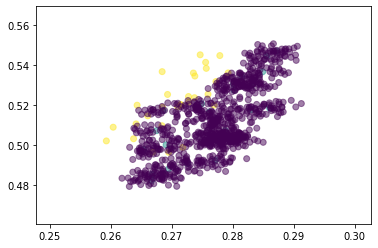

In [120]:

plt.scatter(X_synt[:, 6], X_synt[:, 45], c = 2 - y_synt[:], alpha = 0.5)

In [102]:
	

np.flatnonzero(all_features_names == "ACN9")[0], np.flatnonzero(all_features_names == "ALPK3")[0]

(5799, 10668)

In [103]:
np.flatnonzero(gene_subset_ids == 5799)[0], np.flatnonzero(gene_subset_ids == 10668)[0]

(6, 45)